In [60]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from numpy.linalg import norm


In [61]:
def center_and_crop_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        print(f"Не знайдено обличчя на фото {image_path}")
        return None

    x, y, w, h = faces[0]
    face_center = (x + w // 2, y + h // 2)
    size = 400
    start_x = max(face_center[0] - size // 2, 0)
    start_y = max(face_center[1] - size // 2, 0)
    cropped_img = img[start_y:start_y + size, start_x:start_x + size]
    gray_cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    return gray_cropped_img

In [62]:
input_folder = "training_data"
output_folder = "output_images"
names = ["andrii", "lida", "sofia"]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_folder, filename)
        processed_img = center_and_crop_face(image_path)

        if processed_img is not None:
            folder_name = None
            for name in names:
                if name in filename.lower():
                    folder_name = name
                    break

            if folder_name is None:
                folder_name = "others"

            output_subfolder = os.path.join(output_folder, folder_name)
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)

            output_filename = f"processed_{filename}"
            output_path = os.path.join(output_subfolder, output_filename)
            cv2.imwrite(output_path, processed_img)


In [63]:

def load_images_from_folder(folder, image_size=None):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        try:
            img = Image.open(filepath).convert('L')
            if image_size is not None:
                img = img.resize(image_size)
            img_array = np.array(img, dtype=np.float64)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    return images


In [64]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})



dataset_path = 'output_images'
subjects = os.listdir(dataset_path)
subjects = [s for s in subjects if os.path.isdir(os.path.join(dataset_path, s))]
subject_images = {}
sample_img = load_images_from_folder(os.path.join(dataset_path, subjects[0]))

if len(sample_img) == 0:
    raise ValueError("No images found in the first subject folder.")
img_shape = sample_img[0].shape


print("Image size:", img_shape)


for subject in subjects:
    folder = os.path.join(dataset_path, subject)
    imgs = load_images_from_folder(folder, image_size=img_shape)
    if len(imgs) > 0:
        subject_images[subject] = imgs


all_faces = []
labels = []
for subject, imgs in subject_images.items():
    for img in imgs:
        all_faces.append(img.flatten())
        labels.append(subject)

all_faces = np.array(all_faces).T
print("Training data matrix shape:", all_faces.shape)

Image size: (400, 400)
Training data matrix shape: (160000, 78)


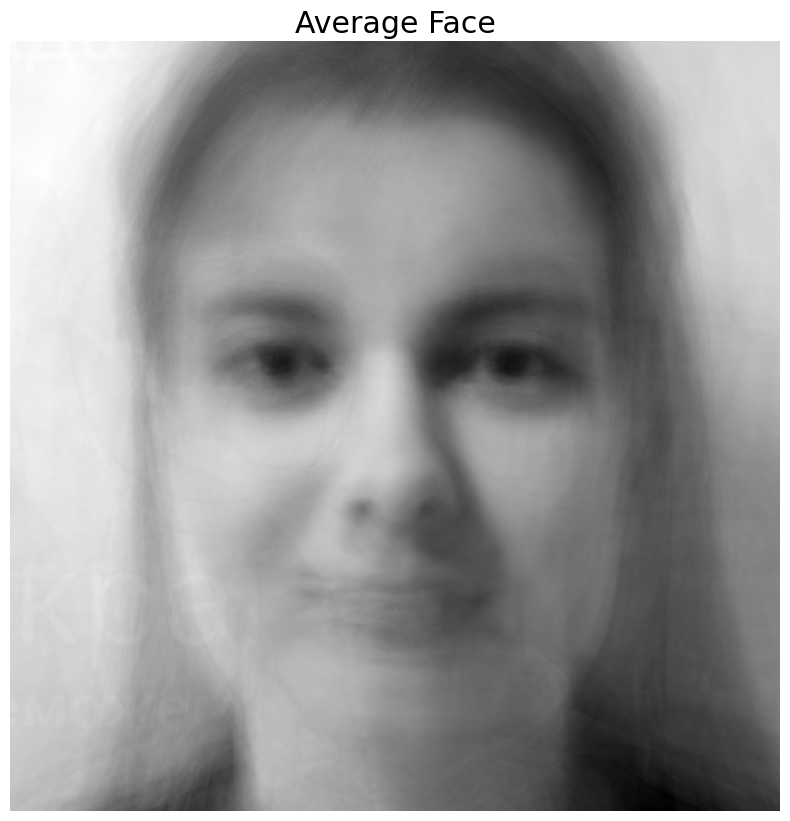

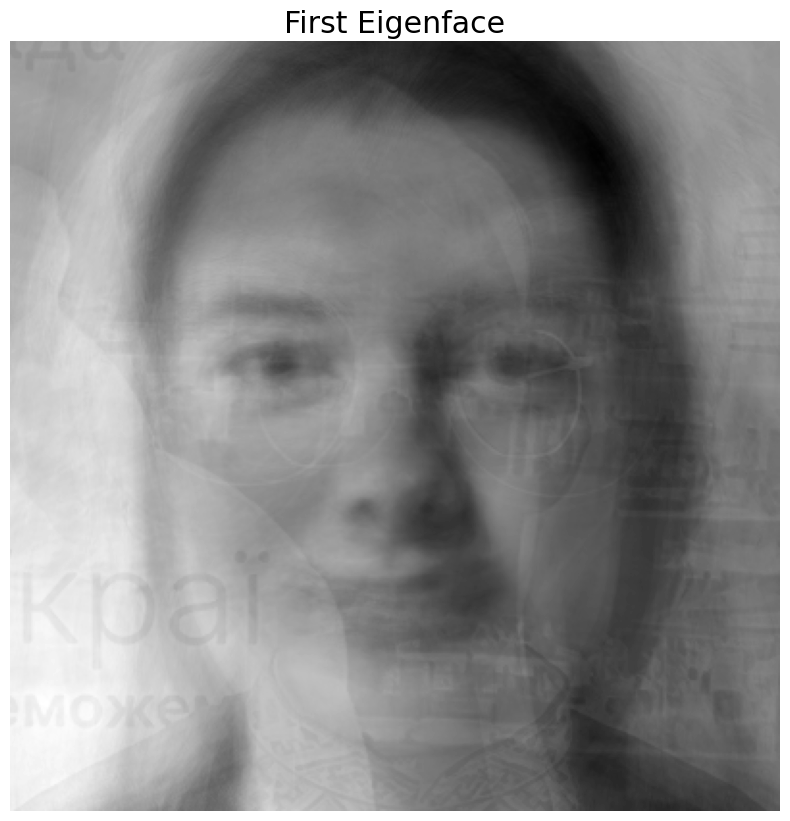

In [65]:
avg_face = np.mean(all_faces, axis=1).reshape(-1, 1)
X = all_faces - np.tile(avg_face, (1, all_faces.shape[1]))

XtX = np.dot(X.T, X)
# print(XtX.size)

def power_method(A, max_iter=1000, tol=1e-6):
    x = np.random.rand(A.shape[1])
    x = x / np.linalg.norm(x)
    for _ in range(max_iter):
        x_new = A @ x
        x_new /= np.linalg.norm(x_new)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    # eigenvalue = x.T @ A @ x
    return x

def top_k_eigenvectors(A, k):
    eigvecs = []
    for _ in range(k):
        v = power_method(A)
        eigvecs.append(v)
        A = A - np.outer(v, A @ v)  # deflation
    return np.stack(eigvecs, axis=1)

eigvecs = top_k_eigenvectors(XtX, all_faces.shape[1])

U_custom = np.dot(X, eigvecs)
eigenfaces = U_custom / np.linalg.norm(U_custom, axis=0)
# U, s, Vt = np.linalg.svd(X, full_matrices=False)

# eigenfaces = U
plt.figure()
plt.imshow(avg_face.reshape(img_shape), cmap='gray')
plt.title("Average Face")
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(eigenfaces[:,0].reshape(img_shape), cmap='gray')
plt.title("First Eigenface")
plt.axis('off')
plt.show()

True
Predicted subject: sofia (True subject: sofia)


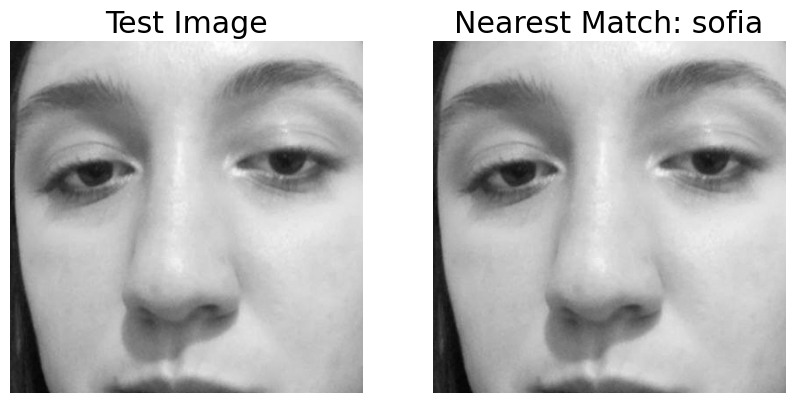

In [67]:
proj_train = eigenfaces.T @ X

def classify_face(test_img, avg_face, eigenfaces, proj_train, labels):
    """
    Given a test image (2D array), subtract the average face, project onto
    eigenfaces, and classify by nearest neighbor in eigenface space.
    """
    test_vector = test_img.flatten().reshape(-1, 1)
    test_vector_centered = test_vector - avg_face
    proj_test = eigenfaces.T @ test_vector_centered

    distances = norm(proj_train - proj_test, axis=0)
    best_match_index = np.argmin(distances)
    predicted_label = labels[best_match_index]
    return predicted_label, distances[best_match_index], proj_test

demo_subject = "sofia"
image_path = "test/sofia11.jpg"
print(os.path.exists(image_path))
demo_img = center_and_crop_face(image_path)
predicted_label, distance, proj_test = classify_face(demo_img, avg_face, eigenfaces, proj_train, labels)
print(f"Predicted subject: {predicted_label} (True subject: {demo_subject})")

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(demo_img, cmap='gray')
plt.title("Test Image")
plt.axis('off')

best_match_vector = all_faces[:, np.argmin(norm(proj_train - proj_test, axis=0))]
best_match_img = best_match_vector.reshape(img_shape)
plt.subplot(1,2,2)
plt.imshow(best_match_img, cmap='gray')
plt.title(f"Nearest Match: {predicted_label}")
plt.axis('off')

plt.show()

In [68]:
eigenvalues = []
for i in range(eigvecs.shape[1]):
    v = eigvecs[:, i]
    eigenvalue = np.dot(v.T, np.dot(XtX, v))
    eigenvalues.append(eigenvalue)

eigenvalues = np.array(eigenvalues)


sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]

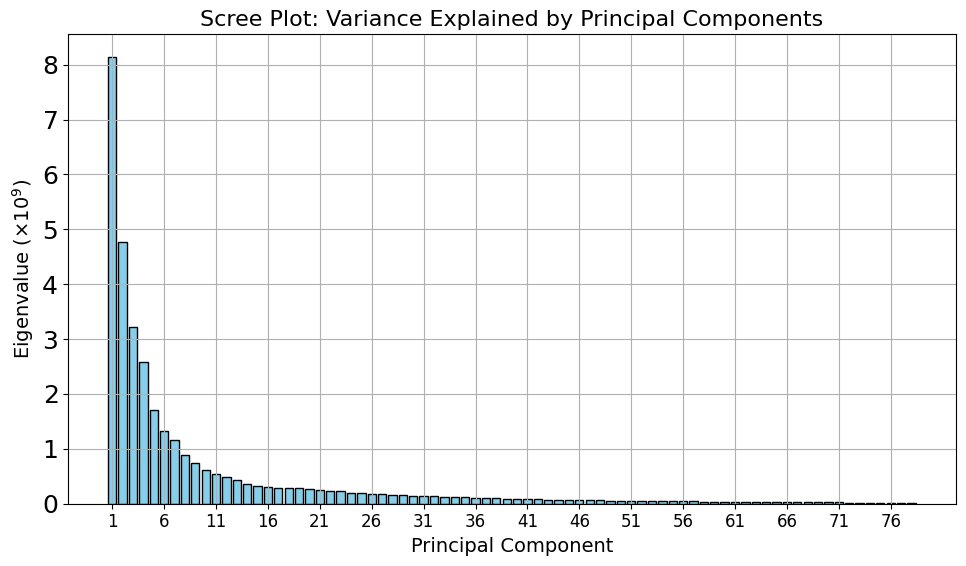

In [69]:
"""Scree Plot"""

import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
component_indices = np.arange(1, len(eigenvalues) + 1)
plt.bar(component_indices, eigenvalues, color='skyblue', edgecolor='black')


ax = plt.gca()
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.yaxis.set_major_formatter(formatter)


plt.draw()
offset_text = ax.yaxis.get_offset_text().get_text()


plt.title("Scree Plot: Variance Explained by Principal Components", fontsize=16)
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel(f"Eigenvalue ({offset_text})", fontsize=14)


ax.yaxis.get_offset_text().set_visible(False)


if len(component_indices) > 20:
    plt.xticks(component_indices[::5], fontsize=12)
else:
    plt.xticks(component_indices, fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


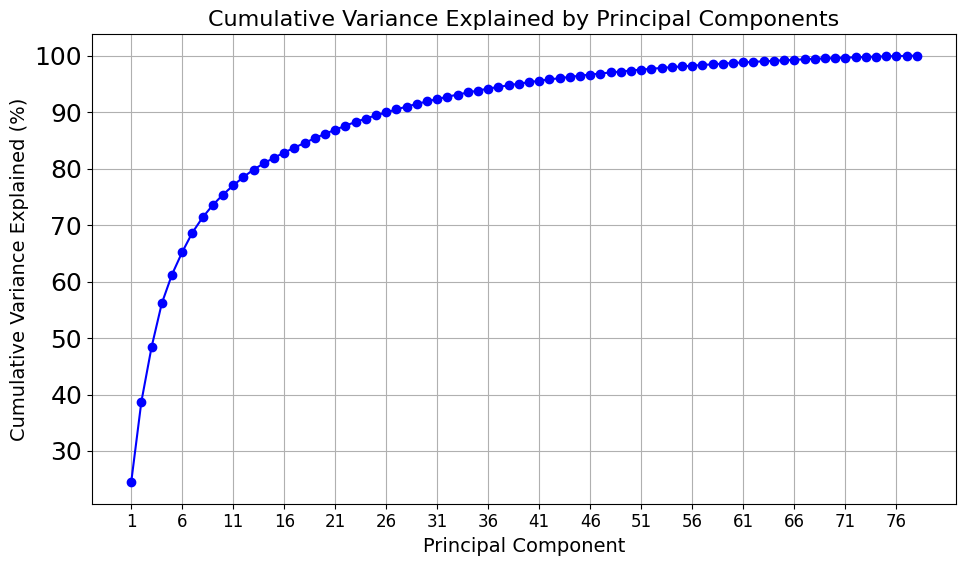

In [70]:
"""Cumulative Variance Explained Plot"""

cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues) * 100


plt.figure(figsize=(10, 6))
component_indices = np.arange(1, len(eigenvalues) + 1)
plt.plot(component_indices, cumulative_variance, marker='o', linestyle='-', color='blue')


plt.title("Cumulative Variance Explained by Principal Components", fontsize=16)
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Cumulative Variance Explained (%)", fontsize=14)


if len(component_indices) > 20:
    plt.xticks(component_indices[::5], fontsize=12)
else:
    plt.xticks(component_indices, fontsize=12)

plt.grid(True)

plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_572\1320411239.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels))


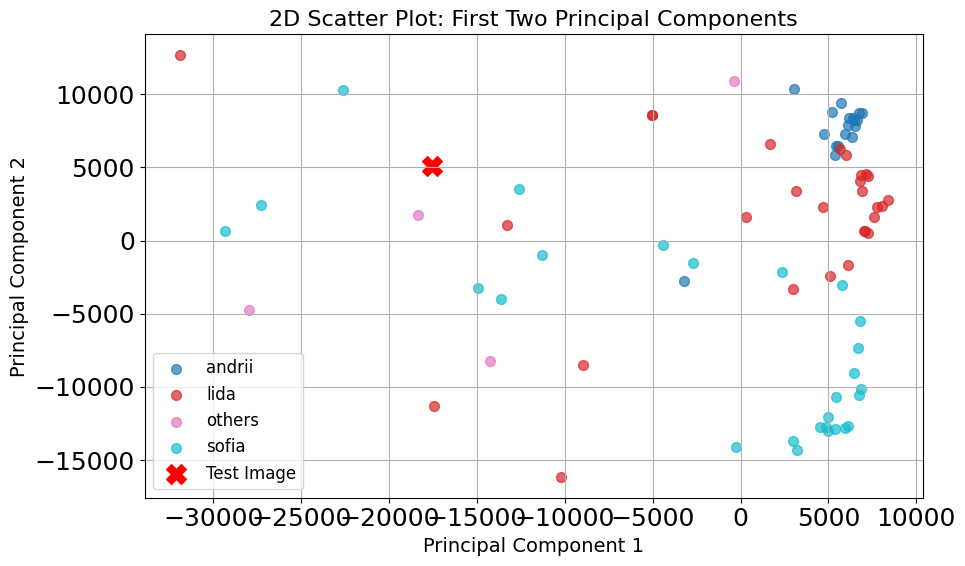

In [71]:
"""2D projection 1st and 2nd Principal Components"""

plt.figure(figsize=(10, 6))


unique_labels = np.unique(labels)

cmap = plt.cm.get_cmap('tab10', len(unique_labels))


for i, subject in enumerate(unique_labels):

    indices = [j for j, lab in enumerate(labels) if lab == subject]

    plt.scatter(proj_train[0, indices], proj_train[1, indices],
                color=cmap(i), label=subject, s=50, alpha=0.7)


if 'proj_test' in globals():
    plt.scatter(proj_test[0], proj_test[1], color='red', marker='X', s=200, label='Test Image')


plt.title("2D Scatter Plot: First Two Principal Components", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)


plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

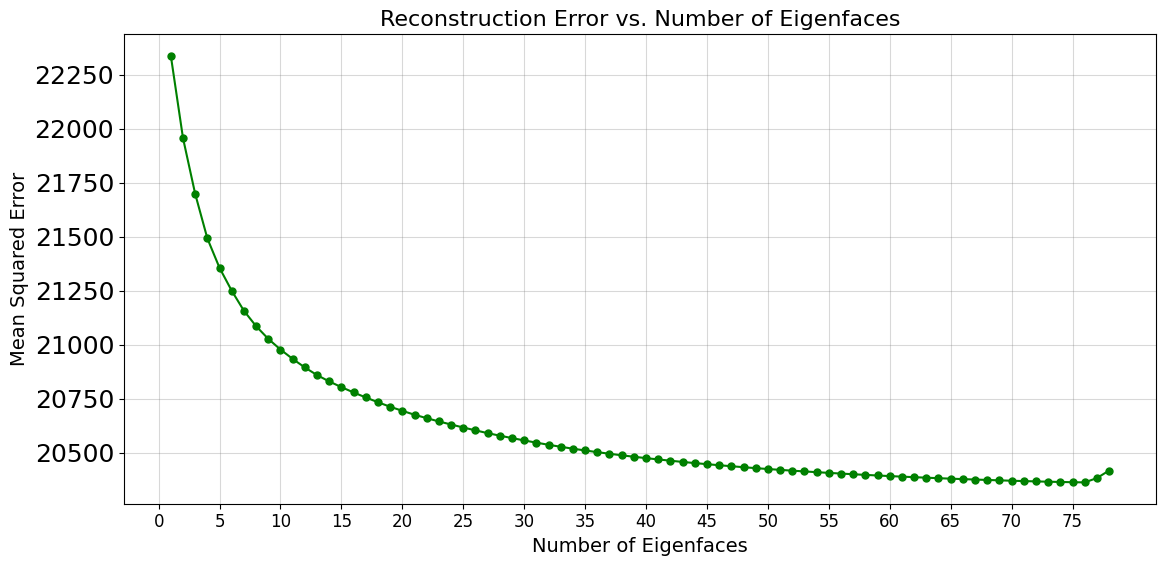

In [72]:
k_max = eigenfaces.shape[1]
reconstruction_errors = []
for k in range(1, k_max + 1):
    proj = eigenfaces[:, :k].T @ X
    X_reconstructed = avg_face + eigenfaces[:, :k] @ proj
    mse = np.mean((X - X_reconstructed) ** 2)
    reconstruction_errors.append(mse)

plt.figure(figsize=(12, 6))
component_range = np.arange(1, k_max + 1)


plt.plot(component_range, reconstruction_errors, marker='o', markersize=5, linestyle='-', color='green')


plt.title("Reconstruction Error vs. Number of Eigenfaces", fontsize=16)
plt.xlabel("Number of Eigenfaces", fontsize=14)
plt.ylabel("Mean Squared Error", fontsize=14)


if k_max > 20:
    plt.xticks(np.arange(0, k_max+1, step=5), fontsize=12)
else:
    plt.xticks(component_range, fontsize=12)


plt.grid(color='gray', alpha=0.3)

plt.tight_layout()
plt.show()

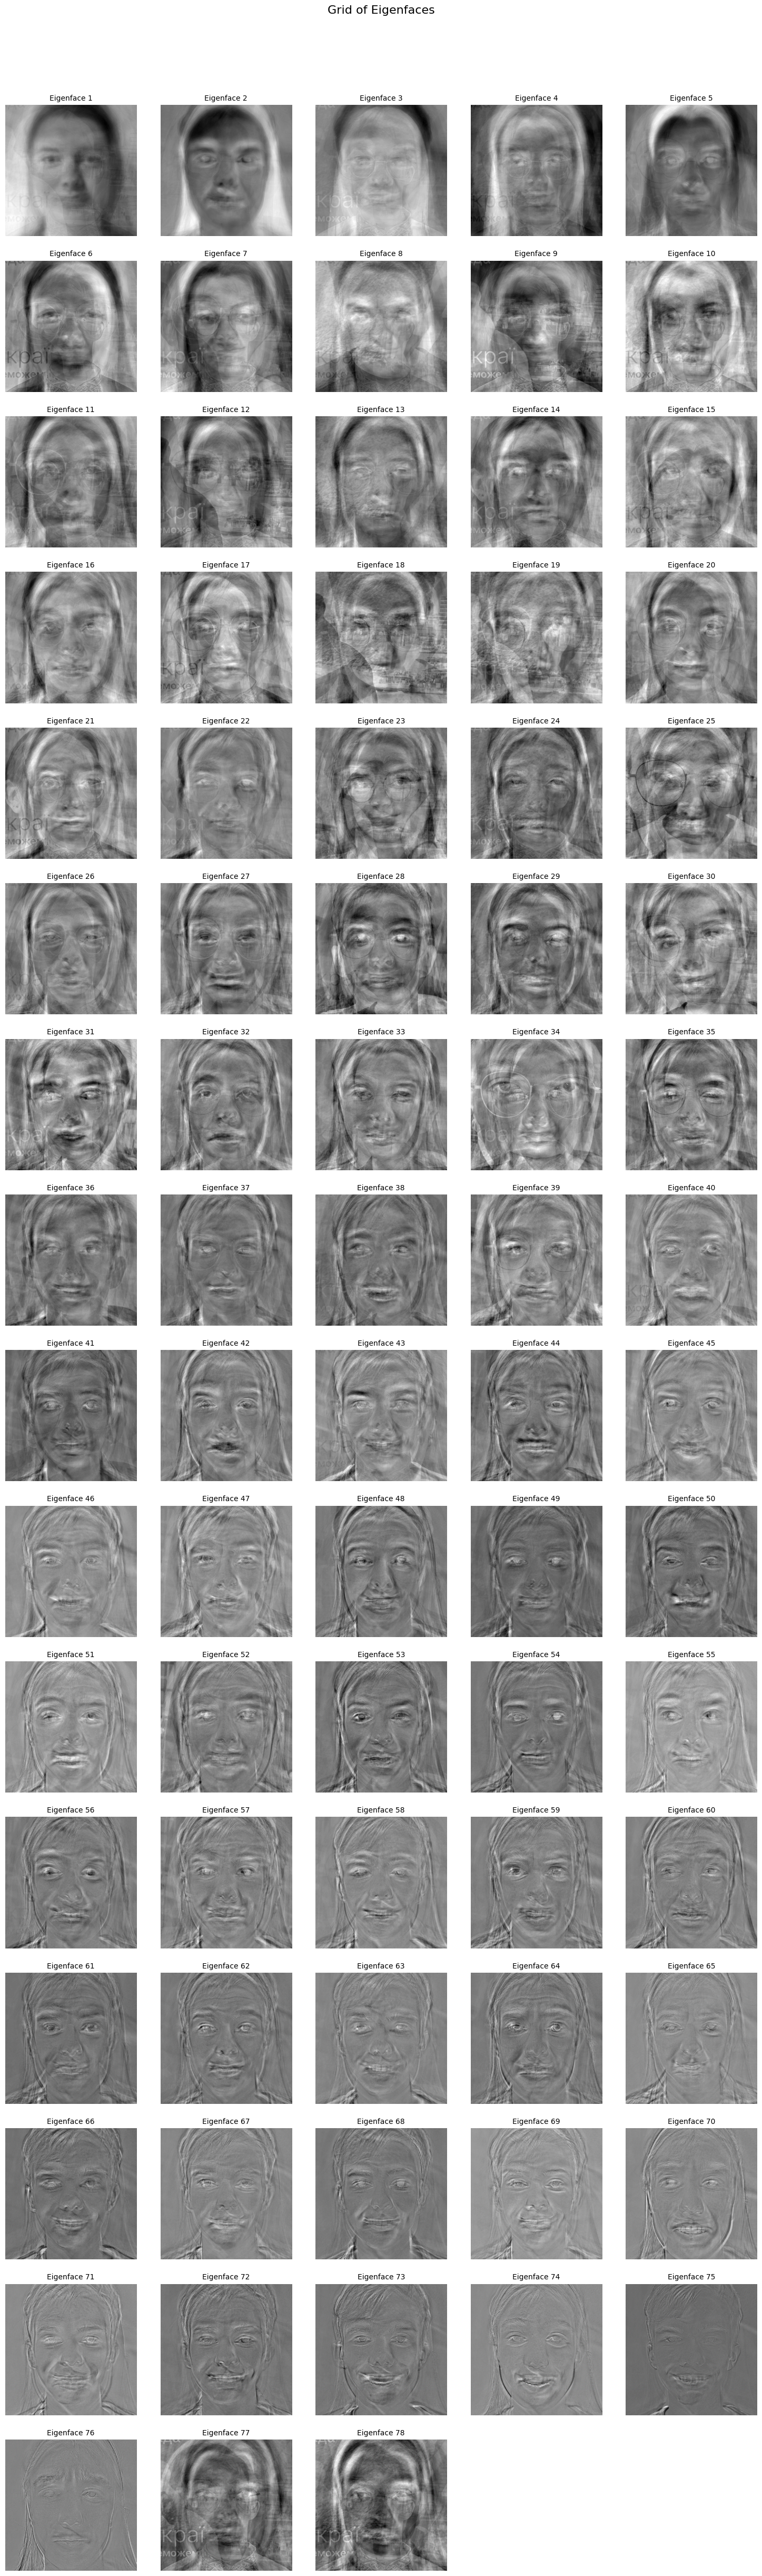

In [73]:
"""Some Eigenfaces"""

n_eigenfaces = eigenfaces.shape[1]


n_cols = 5
n_rows = int(np.ceil(n_eigenfaces / n_cols))

plt.figure(figsize=(15, 3 * n_rows))
for i in range(n_eigenfaces):
    ax = plt.subplot(n_rows, n_cols, i + 1)

    plt.imshow(eigenfaces[:, i].reshape(img_shape), cmap='gray')
    plt.title(f'Eigenface {i + 1}', fontsize=10)
    plt.axis('off')

plt.suptitle('Grid of Eigenfaces', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

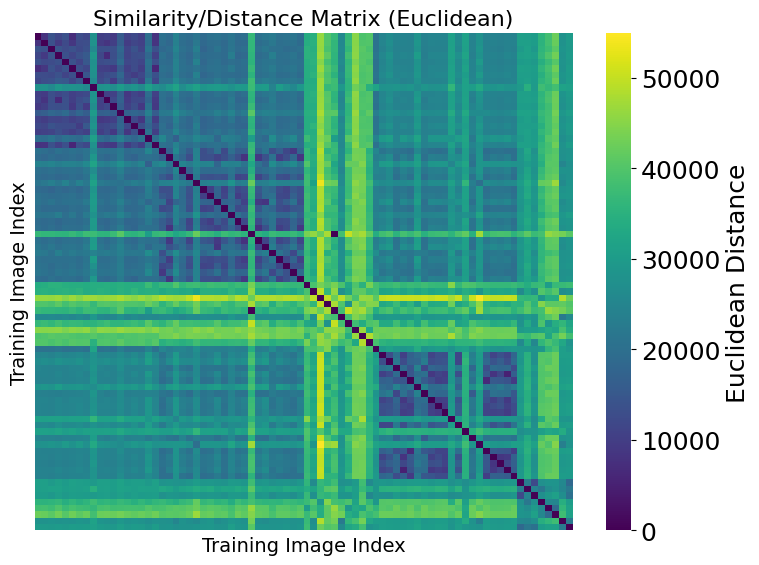

In [74]:
"""Similarity Matrix"""
import seaborn as sns
from scipy.spatial.distance import cdist


distance_matrix = cdist(proj_train.T, proj_train.T, metric='euclidean')

plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix, cmap='viridis', 
            cbar_kws={'label': 'Euclidean Distance'},
            xticklabels=False, yticklabels=False)
plt.title("Similarity/Distance Matrix (Euclidean)", fontsize=16)
plt.xlabel("Training Image Index", fontsize=14)
plt.ylabel("Training Image Index", fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_572\3193151873.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels))


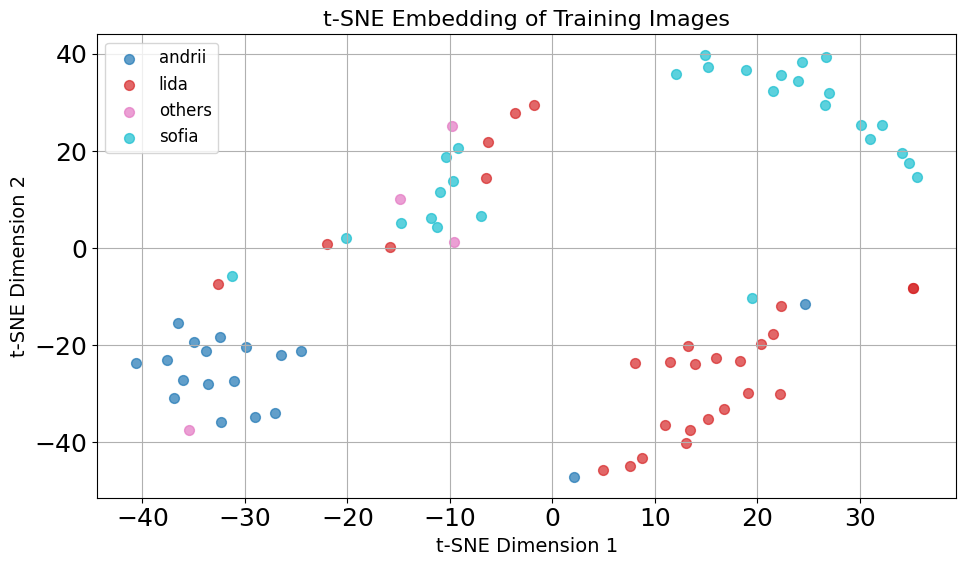

In [75]:
"""t-SNE"""

from sklearn.manifold import TSNE

data_for_tsne = proj_train.T


tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_embedding = tsne.fit_transform(data_for_tsne)


plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels)
cmap = plt.cm.get_cmap('tab10', len(unique_labels))

for i, lab in enumerate(unique_labels):
    indices = [j for j, label in enumerate(labels) if label == lab]
    plt.scatter(tsne_embedding[indices, 0], tsne_embedding[indices, 1],
                color=cmap(i), label=lab, s=50, alpha=0.7)

plt.title("t-SNE Embedding of Training Images", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


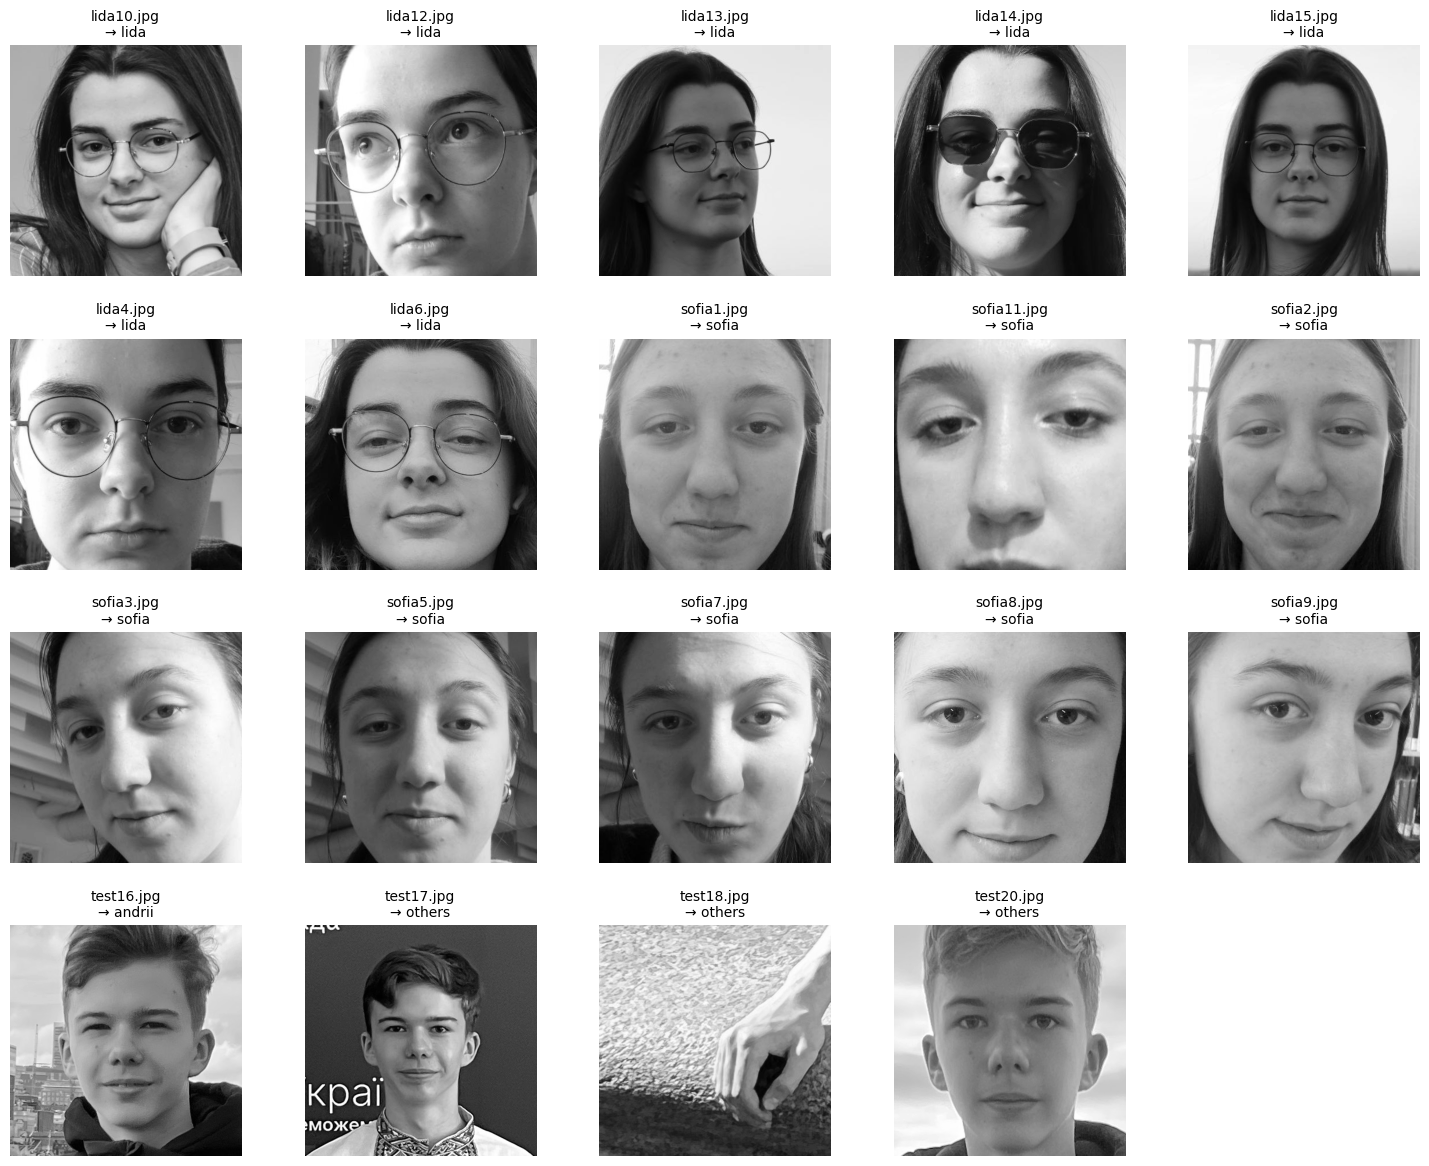

✅ Accuracy: 78.95% (15 / 19)


In [77]:
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from numpy.linalg import norm

names = ["andrii", "lida", "sofia"]

def get_true_label_from_filename(filename, known_names):
    for name in known_names:
        if name in filename.lower():
            return name
    return "UNKNOWN"

test_folder = "test"
test_files = sorted([f for f in os.listdir(test_folder) if f.endswith(".jpg")])
threshold = 20000  # підібрати експериментально

true_labels = []
predicted_labels = []

n_cols = 5
n_rows = (len(test_files) + n_cols - 1) // n_cols
plt.figure(figsize=(15, 3 * n_rows))
grid = gridspec.GridSpec(n_rows, n_cols)

for idx, filename in enumerate(test_files):
    image_path = os.path.join(test_folder, filename)
    test_img = center_and_crop_face(image_path)
    if test_img is None:
        continue

    predicted_label, distance, proj_test = classify_face(test_img, avg_face, eigenfaces, proj_train, labels)

    if distance > threshold:
        predicted_text = "UNKNOWN"
    else:
        predicted_text = predicted_label

    true_label = get_true_label_from_filename(filename, names)
    true_labels.append(true_label)
    predicted_labels.append(predicted_text)

    title = f"{filename}\n→ {predicted_text}"

    ax = plt.subplot(grid[idx])
    ax.imshow(test_img, cmap='gray')
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

correct = sum(t == p for t, p in zip(true_labels, predicted_labels))
accuracy = correct / len(true_labels) * 100
print(f"Accuracy: {accuracy:.2f}% ({correct} / {len(true_labels)})")
